## Prétraitement des données 



In [9]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy.stats import chi2_contingency


%matplotlib inline
sns.set_theme(color_codes=True)

warnings.filterwarnings('ignore')

1- Les données 

In [10]:
path = os.getcwd()
chemin_repertoire = os.path.join(path, '../Data')

# chemin fichier
chemin_data = os.path.join(chemin_repertoire, 'Credit_cleaned.csv')

In [11]:
df = pd.read_csv(chemin_data)
df.head()

,Durations,Credit history,Credit_Purpose,Credit amount,Installment_Rate_Percent,Other debtors / guarantors,Residence_Years,Property,Age in years,Other_Inst_Plans,...,Num_Existing_Credits,Job,Liable_People,Telephone,Foreign worker,Checking_Account_Status,Gender,Status,Years_Employments,Saving_Status
0,6,critical/other existing credit,radio/tv,1169,4,none,4,real estate,67,none,...,2,skilled,1,yes,yes,good,male,single,7 or more years,no savings
1,48,existing paid,radio/tv,5951,2,none,2,real estate,22,none,...,1,skilled,1,none,yes,bad,female,div/dep/mar,1-3 years,less than 100
2,12,critical/other existing credit,education,2096,2,none,3,real estate,49,none,...,1,unskilled_resident,2,none,yes,good,male,single,4-6 years,less than 100
3,42,existing paid,furniture/equipment,7882,2,guarantor,4,life insurance,45,none,...,1,skilled,2,none,yes,good,male,single,4-6 years,less than 100
4,24,delayed previously,new car,4870,3,none,4,no known property,53,none,...,2,skilled,2,none,yes,bad,male,single,1-3 years,less than 100


In [12]:
# renommer les colonnes 
#df.columns

ANALYSE ET RECODAGE DES MODALITES 

In [13]:
# Lister les modalités uniques pour chaque variable catégorielle
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"Modalités de {col} :")
    print(df[col].value_counts())  # Ajoute normalize=True pour voir les proportions
    print("-" * 40)

Modalités de Credit history :
Credit history
existing paid                     530
critical/other existing credit    293
delayed previously                 88
all paid                           49
no credits/all paid                40
Name: count, dtype: int64
----------------------------------------
Modalités de Credit_Purpose :
Credit_Purpose
radio/tv               280
new car                234
furniture/equipment    181
used car               103
business                97
education               50
repairs                 22
domestic appliance      12
other                   12
retraining               9
Name: count, dtype: int64
----------------------------------------
Modalités de Other debtors / guarantors :
Other debtors / guarantors
none            907
guarantor        52
co applicant     41
Name: count, dtype: int64
----------------------------------------
Modalités de Property :
Property
car                  332
real estate          282
life insurance       232
no known pro

 Une analyse rapide avec des propositions des variables catégorielles nous suggère un regroupements pour simplifier les modalités de certaines variables catégorielles, en particulier celles déséquilibrées ou très fragmentées.

**job** :  Regrouper les 2 dernières en une seule catégorie "other" est aussi envisageable si tu veux simplifier encore plus. 

**Foreign worker** : Très déséquilibrée, à supprimer (déjà suggéré plus haut), car elle n’apporte pas de diversité significative.

**Telephone** : Binaire, pas besoin de regroupement. Mais comme dit précédemment, tu peux la supprimer si elle est redondante avec Job.

**Status** : mar/wid et div/sep ensemble si tu veux 2 classes seulement : `single` vs `not_single`.

**Years_Employments** : regrouper en `short`, `mid`, `long` et  `unemployed`  Cela te donne une variable plus stable avec 4 modalités maximum.

**Saving_Status** : regrouper en 3 modalités `low`, `medium`  et `high`
pour avoir une variable plus stable avec 3 modalités maximum.

**Gender** (69% homme) : >Variable binaire. Si tu la gardes, tu peux la garder telle quelle, mais comme elle est très corrélée à Foreign worker, tu peux la supprimer aussi.



Suppression de certaines variables juger pas pertinente pour la modélisation  

In [14]:
#df.columns
#df.shape

In [15]:
# Supposons de certaines variables ton DataFrame df jugée pas trop pertinent pour notre objectif
variables_a_supprimer = ['Gender', 'Telephone', 'Housing', 'Foreign worker']

# Suppression des colonnes
df = df.drop(columns=variables_a_supprimer)

# Vérification
print("Colonnes restantes :", df.columns.tolist())
print("la dimension :", df.shape)

Colonnes restantes : ['Durations', 'Credit history', 'Credit_Purpose', 'Credit amount', 'Installment_Rate_Percent', 'Other debtors / guarantors', 'Residence_Years', 'Property', 'Age in years', 'Other_Inst_Plans', 'Num_Existing_Credits', 'Job', 'Liable_People', 'Checking_Account_Status', 'Status', 'Years_Employments', 'Saving_Status']
la dimension : (1000, 17)


**Regroupement des modalités**

In [16]:
# Regroupement des modalités pour la variable Job
df['Job_Grouped'] = df['Job'].replace({
    'skilled': 'skilled',
    'unskilled_resident': 'unskilled',
    'high_qualif_self_emp_mgmt': 'qualified',
    'unemp_unskilled_non_res': 'unskilled'  # ou 'other' si tu veux une classe à part
})

# Regroupement pour Status
df['Status_Grouped'] = df['Status'].replace({
    'single': 'single',
    'div/dep/mar': 'not_single',
    'mar/wid': 'not_single',
    'div/sep': 'not_single'
})

# Regroupement pour Years_Employments
df['Years_Employments_Grouped'] = df['Years_Employments'].replace({
    'less than 1 year': 'short',
    '1-3 years': 'short',
    '4-6 years': 'mid',
    '7 or more years': 'long',
    'unemployed': 'unemployed'
})

# Regroupement pour Saving_Status
df['Saving_Status_Grouped'] = df['Saving_Status'].replace({
    'no savings': 'low',
    'less than 100': 'low',
    '100-500': 'medium',
    '500-1000': 'high',
    'more than 1000': 'high'
})

# Regroupement pour Credit_Purpose
df['Credit_Purpose_Grouped'] = df['Credit_Purpose'].replace({
    'radio/tv': 'electronics',
    'domestic appliance': 'electronics',
    'furniture/equipment': 'household',
    'repairs': 'household',
    'new car': 'car',
    'used car': 'car',
    'education': 'education',
    'retraining': 'education',
    'business': 'business',
    'other': 'other'
})

# Regroupement pour Credit history
df['Credit_History_Grouped'] = df['Credit history'].replace({
    'no credits/all paid': 'good',
    'all paid': 'good',
    'existing paid': 'average',
    'delayed previously': 'poor',
    'critical/other existing credit': 'critical'
})


# Suppression des anciennes colonnes après regroupement
df = df.drop(columns=['Job', 'Status', 'Years_Employments', 'Saving_Status', 'Credit_Purpose', 'Credit history'])

# Vérification rapide
print("Nouvelles colonnes ajoutées :", ['Job_Grouped', 'Status_Grouped', 'Years_Employments_Grouped', 'Saving_Status_Grouped', 'Credit_Purpose_Grouped','Credit_History_Grouped'])


Nouvelles colonnes ajoutées : ['Job_Grouped', 'Status_Grouped', 'Years_Employments_Grouped', 'Saving_Status_Grouped', 'Credit_Purpose_Grouped', 'Credit_History_Grouped']


**Renommer les colonnes regroupées**

In [17]:
df.head(2)

,Durations,Credit amount,Installment_Rate_Percent,Other debtors / guarantors,Residence_Years,Property,Age in years,Other_Inst_Plans,Num_Existing_Credits,Liable_People,Checking_Account_Status,Job_Grouped,Status_Grouped,Years_Employments_Grouped,Saving_Status_Grouped,Credit_Purpose_Grouped,Credit_History_Grouped
0,6,1169,4,none,4,real estate,67,none,2,1,good,skilled,single,long,low,electronics,critical
1,48,5951,2,none,2,real estate,22,none,1,1,bad,skilled,not_single,short,low,electronics,average


In [18]:

df = df.rename(columns={
    'Job_Grouped': 'Job',
    'Status_Grouped': 'Status',
    'Years_Employments_Grouped': 'Years_Employments',
    'Saving_Status_Grouped': 'Saving_Status',
    'Credit_Purpose_Grouped': 'Credit_Purpose',
    'Credit_History_Grouped': 'Credit_history',
    'Credit amount' : 'Credit_amount',
    'Other debtors / guarantors': 'Other_debtors_guarantors',
    'Age in years' : 'Age', 
    'Foreign worker' : 'Foreign_worker'
    
    
})

# Vérification
print("Colonnes renommées :", df.columns.tolist())

Colonnes renommées : ['Durations', 'Credit_amount', 'Installment_Rate_Percent', 'Other_debtors_guarantors', 'Residence_Years', 'Property', 'Age', 'Other_Inst_Plans', 'Num_Existing_Credits', 'Liable_People', 'Checking_Account_Status', 'Job', 'Status', 'Years_Employments', 'Saving_Status', 'Credit_Purpose', 'Credit_history']


In [19]:
df.head(3)

,Durations,Credit_amount,Installment_Rate_Percent,Other_debtors_guarantors,Residence_Years,Property,Age,Other_Inst_Plans,Num_Existing_Credits,Liable_People,Checking_Account_Status,Job,Status,Years_Employments,Saving_Status,Credit_Purpose,Credit_history
0,6,1169,4,none,4,real estate,67,none,2,1,good,skilled,single,long,low,electronics,critical
1,48,5951,2,none,2,real estate,22,none,1,1,bad,skilled,not_single,short,low,electronics,average
2,12,2096,2,none,3,real estate,49,none,1,2,good,unskilled,single,mid,low,education,critical


In [20]:
#df.columns

## Modélisation

In [21]:
# Copier le dataset pour éviter de modifier l'original
df_prep = df.copy()
df_prep.head(5)

,Durations,Credit_amount,Installment_Rate_Percent,Other_debtors_guarantors,Residence_Years,Property,Age,Other_Inst_Plans,Num_Existing_Credits,Liable_People,Checking_Account_Status,Job,Status,Years_Employments,Saving_Status,Credit_Purpose,Credit_history
0,6,1169,4,none,4,real estate,67,none,2,1,good,skilled,single,long,low,electronics,critical
1,48,5951,2,none,2,real estate,22,none,1,1,bad,skilled,not_single,short,low,electronics,average
2,12,2096,2,none,3,real estate,49,none,1,2,good,unskilled,single,mid,low,education,critical
3,42,7882,2,guarantor,4,life insurance,45,none,1,2,good,skilled,single,mid,low,household,average
4,24,4870,3,none,4,no known property,53,none,2,2,bad,skilled,single,short,low,car,poor


In [22]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Durations                 1000 non-null   int64 
 1   Credit_amount             1000 non-null   int64 
 2   Installment_Rate_Percent  1000 non-null   int64 
 3   Other_debtors_guarantors  1000 non-null   object
 4   Residence_Years           1000 non-null   int64 
 5   Property                  1000 non-null   object
 6   Age                       1000 non-null   int64 
 7   Other_Inst_Plans          1000 non-null   object
 8   Num_Existing_Credits      1000 non-null   int64 
 9   Liable_People             1000 non-null   int64 
 10  Checking_Account_Status   1000 non-null   object
 11  Job                       1000 non-null   object
 12  Status                    1000 non-null   object
 13  Years_Employments         1000 non-null   object
 14  Saving_Status            

In [23]:
#cat =df_prep.select_dtypes(include=['object', 'category']).columns
#num= df_prep.select_dtypes(include=['int', 'float']).columns

**Encodage des variables**

pour l'encodage on exclut la variable `Durations` des variables sélection pour éviter **la multicolinéarité** vu qu'elle est coorélé avec montant de crédit `Credit amount` 

In [24]:
num_features = ['Credit_amount', 'Installment_Rate_Percent', 'Residence_Years', 'Age', 'Num_Existing_Credits', 'Liable_People'] 
cat_features =  ['Other_debtors_guarantors', 'Property', 'Other_Inst_Plans', 'Job', 'Status', 'Years_Employments', 'Saving_Status', 'Credit_Purpose', 'Credit_history'] 

In [25]:



# Appliquer une transformation log sur "Credit amount" pour réduire l'impact des valeurs extrêmes (réduit l’effet des outliers ✔️)
df_prep["Credit_amount"] = np.log1p(df_prep["Credit_amount"])

# Normalisation des variables numériques
scaler = StandardScaler()
df_prep[num_features] = scaler.fit_transform(df_prep[num_features])

# Encodage One-Hot des variables catégorielles
df_prep = pd.get_dummies(df_prep, columns=cat_features, drop_first=True)

In [26]:
df_prep.columns

Index(['Durations', 'Credit_amount', 'Installment_Rate_Percent',
       'Residence_Years', 'Age', 'Num_Existing_Credits', 'Liable_People',
       'Checking_Account_Status', 'Other_debtors_guarantors_guarantor',
       'Other_debtors_guarantors_none', 'Property_life insurance',
       'Property_no known property', 'Property_real estate',
       'Other_Inst_Plans_none', 'Other_Inst_Plans_stores', 'Job_skilled',
       'Job_unskilled', 'Status_single', 'Years_Employments_mid',
       'Years_Employments_short', 'Years_Employments_unemployed',
       'Saving_Status_low', 'Saving_Status_medium', 'Credit_Purpose_car',
       'Credit_Purpose_education', 'Credit_Purpose_electronics',
       'Credit_Purpose_household', 'Credit_Purpose_other',
       'Credit_history_critical', 'Credit_history_good',
       'Credit_history_poor'],
      dtype='object')

In [27]:
# Séparation des variables X et de la cible y 

# Encodage de la variable cible (Checking_Account_Status : Good -> 0, Bad -> 1)
#label_encoder = LabelEncoder()
#df_prep["Checking_Account_Status"] = label_encoder.fit_transform(df_prep["Checking_Account_Status"])
#label_encoder.classes_


y = df_prep["Checking_Account_Status"].apply(lambda x: 1 if x == 'bad' else 0)
#y.value_counts()

X = df_prep.drop(columns=['Checking_Account_Status', 'Durations'])

Encodage de y 

df_prep["Checking_Account_Status"] == 'good' --> 0

df_prep ["Checking_Account_Status"] == 'Bad' --> 1

In [28]:
X.columns

Index(['Credit_amount', 'Installment_Rate_Percent', 'Residence_Years', 'Age',
       'Num_Existing_Credits', 'Liable_People',
       'Other_debtors_guarantors_guarantor', 'Other_debtors_guarantors_none',
       'Property_life insurance', 'Property_no known property',
       'Property_real estate', 'Other_Inst_Plans_none',
       'Other_Inst_Plans_stores', 'Job_skilled', 'Job_unskilled',
       'Status_single', 'Years_Employments_mid', 'Years_Employments_short',
       'Years_Employments_unemployed', 'Saving_Status_low',
       'Saving_Status_medium', 'Credit_Purpose_car',
       'Credit_Purpose_education', 'Credit_Purpose_electronics',
       'Credit_Purpose_household', 'Credit_Purpose_other',
       'Credit_history_critical', 'Credit_history_good',
       'Credit_history_poor'],
      dtype='object')

In [29]:
print('taille de X :',  X.shape)
print('taille de y :',  y.shape)

taille de X : (1000, 29)
taille de y : (1000,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('taille de X_train :',  X_train.shape)
print('taille de y_train :',  y_train.shape) 
print('taille de X_test :',  X_test.shape)
print('taille de y_test :',  y_test.shape)

taille de X_train : (800, 29)
taille de y_train : (800,)
taille de X_test : (200, 29)
taille de y_test : (200,)


Suréchantillonnage avec `SMOTE` pour équilibrer les modalité de y 

In [31]:
# pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Avant SMOTE :", X_train.shape, y_train.value_counts().to_dict())
print("Après SMOTE :", X_train_res.shape, pd.Series(y_train_res).value_counts().to_dict())


Avant SMOTE : (800, 29) {0: 559, 1: 241}
Après SMOTE : (1118, 29) {1: 559, 0: 559}


In [32]:
y_train_res.value_counts()

Checking_Account_Status
1    559
0    559
Name: count, dtype: int64

In [33]:
X_train_res.columns

Index(['Credit_amount', 'Installment_Rate_Percent', 'Residence_Years', 'Age',
       'Num_Existing_Credits', 'Liable_People',
       'Other_debtors_guarantors_guarantor', 'Other_debtors_guarantors_none',
       'Property_life insurance', 'Property_no known property',
       'Property_real estate', 'Other_Inst_Plans_none',
       'Other_Inst_Plans_stores', 'Job_skilled', 'Job_unskilled',
       'Status_single', 'Years_Employments_mid', 'Years_Employments_short',
       'Years_Employments_unemployed', 'Saving_Status_low',
       'Saving_Status_medium', 'Credit_Purpose_car',
       'Credit_Purpose_education', 'Credit_Purpose_electronics',
       'Credit_Purpose_household', 'Credit_Purpose_other',
       'Credit_history_critical', 'Credit_history_good',
       'Credit_history_poor'],
      dtype='object')

**Entrainement des modèles**

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

Regression Logistique 

In [35]:
# Création du modèle de régression logistique
log_reg = LogisticRegression()

# Entraînement du modèle
log_reg.fit(X_train_res, y_train_res)

# Prédiction sur les données de test
y_pred = log_reg.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("LogisticRegression Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

LogisticRegression Accuracy: 0.685
Confusion Matrix:
 [[104  37]
 [ 26  33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       141
           1       0.47      0.56      0.51        59

    accuracy                           0.69       200
   macro avg       0.64      0.65      0.64       200
weighted avg       0.70      0.69      0.69       200



Random Forest

In [36]:
# Création et entraînement du modèle Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train_res, y_train_res)

# Prédiction sur l'ensemble de test
y_pred_rf = random_forest.predict(X_test)

# Évaluation du modèle Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)
print("Confusion Matrix:\n", conf_matrix_rf)
print("Classification Report:\n", report_rf)

Random Forest Accuracy: 0.665
Confusion Matrix:
 [[116  25]
 [ 42  17]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.82      0.78       141
           1       0.40      0.29      0.34        59

    accuracy                           0.67       200
   macro avg       0.57      0.56      0.56       200
weighted avg       0.64      0.67      0.65       200



Decision Tree

In [37]:
# Création et entraînement du modèle Arbre de Décision
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_res, y_train_res)

# Prédiction sur l'ensemble de test
y_pred_dt = decision_tree.predict(X_test)

# Évaluation du modèle Arbre de Décision
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree Accuracy:", accuracy_dt)
print("Confusion Matrix:\n", conf_matrix_dt)
print("Classification Report:\n", report_dt)

Decision Tree Accuracy: 0.635
Confusion Matrix:
 [[99 42]
 [31 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73       141
           1       0.40      0.47      0.43        59

    accuracy                           0.64       200
   macro avg       0.58      0.59      0.58       200
weighted avg       0.65      0.64      0.64       200



Xgboost

In [38]:
# Création et entraînement du modèle XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_res, y_train_res)

# Prédiction sur l'ensemble de test
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation du modèle XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print("XGBoost Accuracy:", accuracy_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)
print("Classification Report:\n", report_xgb)

XGBoost Accuracy: 0.69
Confusion Matrix:
 [[115  26]
 [ 36  23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       141
           1       0.47      0.39      0.43        59

    accuracy                           0.69       200
   macro avg       0.62      0.60      0.61       200
weighted avg       0.68      0.69      0.68       200



**Résultats**

In [39]:

# Créer un tableau de résultats à la main
results = [
    {
        "Modèle": "Logistic Regression",
        "Accuracy": 0.685,
        "Precision (1)": 0.47,
        "Recall (1)": 0.56,
        "F1-score (1)": 0.51
    },
    {
        "Modèle": "Random Forest",
        "Accuracy": 0.665,
        "Precision (1)": 0.40,
        "Recall (1)": 0.29,
        "F1-score (1)": 0.34
    },
    {
        "Modèle": "Decision Tree",
        "Accuracy": 0.635,
        "Precision (1)": 0.40,
        "Recall (1)": 0.47,
        "F1-score (1)": 0.43
    },
    {
        "Modèle": "XGBoost",
        "Accuracy": 0.690,
        "Precision (1)": 0.47,
        "Recall (1)": 0.39,
        "F1-score (1)": 0.43
    }
]

# Création du DataFrame
df_models = pd.DataFrame(results)

# Affichage
df_models


,Modèle,Accuracy,Precision (1),Recall (1),F1-score (1)
0,Logistic Regression,0.685,0.47,0.56,0.51
1,Random Forest,0.665,0.40,0.29,0.34
2,Decision Tree,0.635,0.40,0.47,0.43
3,XGBoost,0.690,0.47,0.39,0.43


In [45]:
#df_models.to_markdown

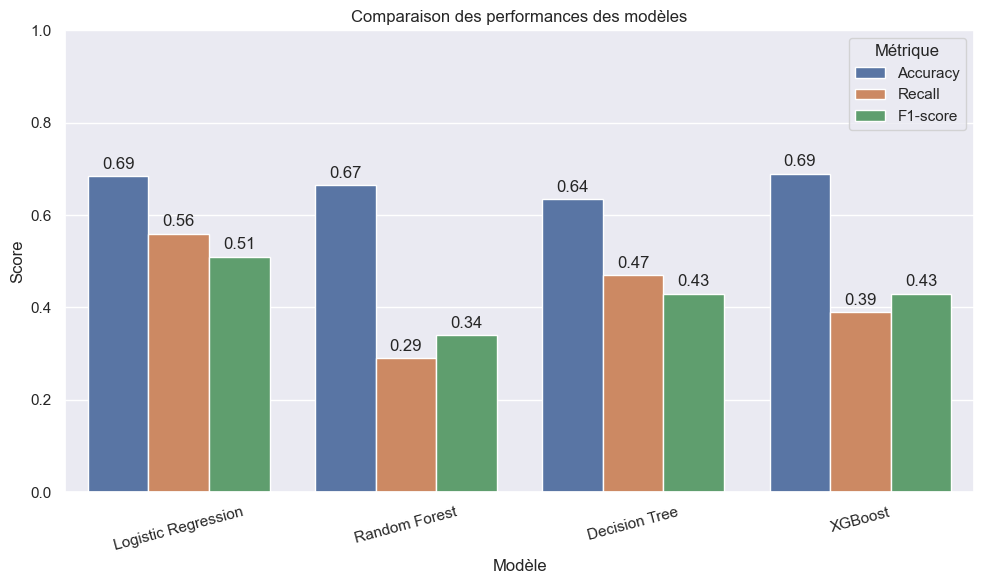

In [213]:
results = {
    'Logistic Regression': {'Accuracy': 0.685, 'Recall': 0.56, 'F1-score': 0.51},
    'Random Forest': {'Accuracy': 0.665, 'Recall': 0.29, 'F1-score': 0.34},
    'Decision Tree': {'Accuracy': 0.635, 'Recall': 0.47, 'F1-score': 0.43},
    'XGBoost': {'Accuracy': 0.690, 'Recall': 0.39, 'F1-score': 0.43}
}

# Transformation en DataFrame
df_scores = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Modèle'})

# Transformation pour seaborn (long format)
df_long = df_scores.melt(id_vars='Modèle', var_name='Métrique', value_name='Score')

# Création du plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long, x='Modèle', y='Score', hue='Métrique')

# Affichage des valeurs sur les barres
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.title('Comparaison des performances des modèles')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xticks(rotation=15)
plt.legend(title='Métrique')
plt.tight_layout()
plt.show()

**Commentaires**


✅ Logistic Regression :
Le meilleur compromis entre recall, precision et F1-score sur la classe 1

Recall (0.56) → il détecte plus de "bad" que les autres

C’est un modèle simple et robuste, qui semble très bien s’en sortir ici

✅ XGBoost :
Meilleure accuracy générale (0.690)

Mais recall plus faible (0.39) → il rate plus de "bad"

F1-score correct (0.43) → mais un peu en dessous de la régression logistique

⚠️ Random Forest :
Recall très faible (0.29) → il rate 71% des "bad"

F1-score le plus bas

Pas fiable pour ton objectif

⚠️ Decision Tree :
Recall correct (0.47), mieux que RF

Mais f1-score moyen (0.43)

Peut être utile comme base, mais moins performant que logistic/XGB



Courbe ROC 

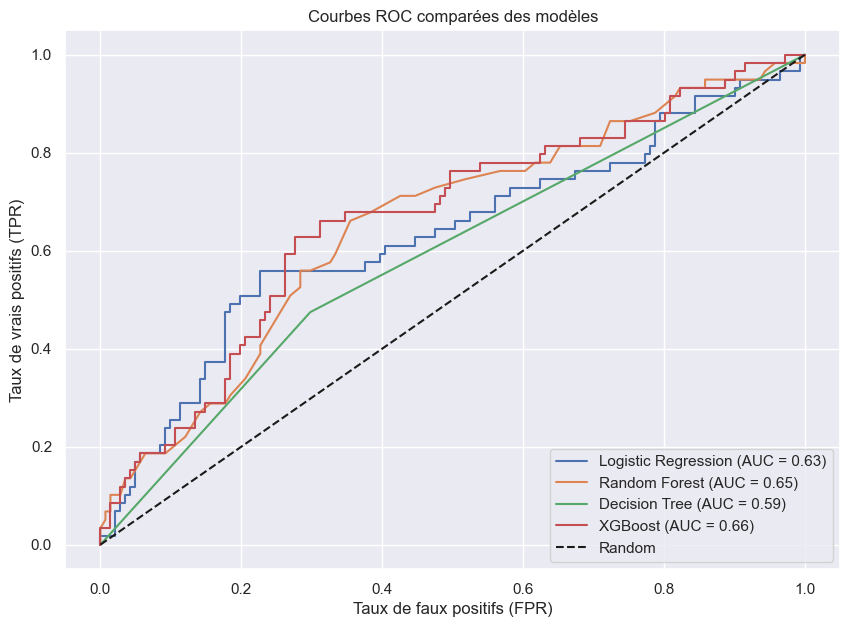

In [214]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcul des probabilités pour chaque modèle
y_proba_logreg = log_reg.predict_proba(X_test)[:, 1]
y_proba_rf     = random_forest .predict_proba(X_test)[:, 1]
y_proba_dt     = decision_tree.predict_proba(X_test)[:, 1]
y_proba_xgb    = xgb_model.predict_proba(X_test)[:, 1]

# Calcul des courbes ROC
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_proba_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# Calcul des AUC
auc_logreg = roc_auc_score(y_test, y_proba_logreg)
auc_rf = roc_auc_score(y_test, y_proba_rf)
auc_dt = roc_auc_score(y_test, y_proba_dt)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Tracer les courbes ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')

# Ligne diagonale
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbes ROC comparées des modèles')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Sauvegarde du modèle regression logistic**

In [216]:
import joblib

# Sauvegarde du modèle
joblib.dump(log_reg, "logistic_model.pkl")
joblib.dump(scaler, "scaler.pkl")  # si tu normalises
joblib.dump(list(X.columns), "features_columns.pkl")

['features_columns.pkl']

In [218]:
#X.columns

In [ ]:
features_columns = joblib.load('features_columns.pkl')
features_columns

['Credit_amount',
 'Installment_Rate_Percent',
 'Residence_Years',
 'Age',
 'Num_Existing_Credits',
 'Liable_People',
 'Other_debtors_guarantors_guarantor',
 'Other_debtors_guarantors_none',
 'Property_life insurance',
 'Property_no known property',
 'Property_real estate',
 'Other_Inst_Plans_none',
 'Other_Inst_Plans_stores',
 'Job_skilled',
 'Job_unskilled',
 'Status_single',
 'Years_Employments_mid',
 'Years_Employments_short',
 'Years_Employments_unemployed',
 'Saving_Status_low',
 'Saving_Status_medium',
 'Credit_Purpose_car',
 'Credit_Purpose_education',
 'Credit_Purpose_electronics',
 'Credit_Purpose_household',
 'Credit_Purpose_other',
 'Credit_history_critical',
 'Credit_history_good',
 'Credit_history_poor']

In [223]:
X.columns

Index(['Credit_amount', 'Installment_Rate_Percent', 'Residence_Years', 'Age',
       'Num_Existing_Credits', 'Liable_People',
       'Other_debtors_guarantors_guarantor', 'Other_debtors_guarantors_none',
       'Property_life insurance', 'Property_no known property',
       'Property_real estate', 'Other_Inst_Plans_none',
       'Other_Inst_Plans_stores', 'Job_skilled', 'Job_unskilled',
       'Status_single', 'Years_Employments_mid', 'Years_Employments_short',
       'Years_Employments_unemployed', 'Saving_Status_low',
       'Saving_Status_medium', 'Credit_Purpose_car',
       'Credit_Purpose_education', 'Credit_Purpose_electronics',
       'Credit_Purpose_household', 'Credit_Purpose_other',
       'Credit_history_critical', 'Credit_history_good',
       'Credit_history_poor'],
      dtype='object')

Regression Logistique 

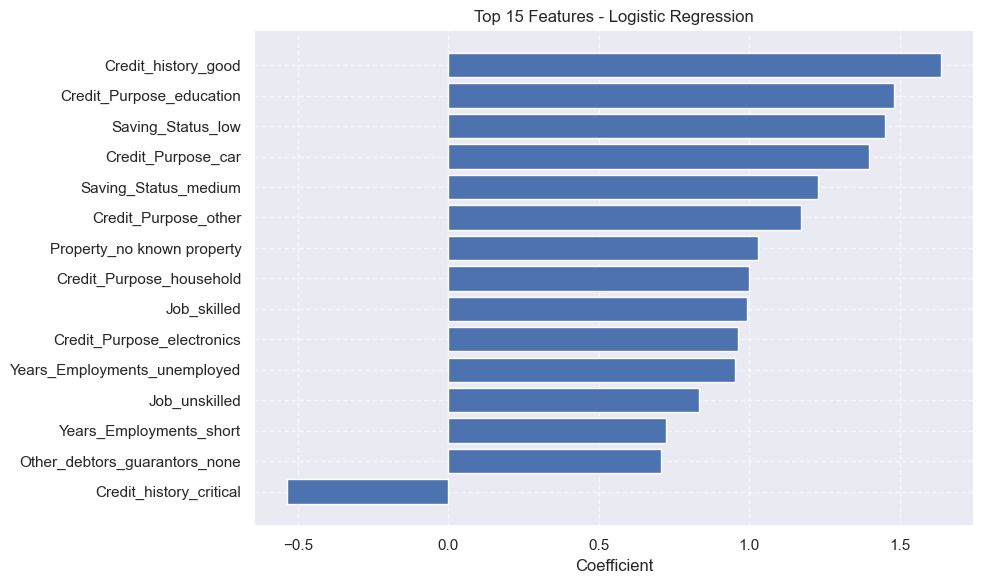

In [219]:
coefficients = log_reg.coef_[0] 
feature_names = X.columns

# Création d'un DataFrame avec les coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'AbsCoefficient': np.abs(coefficients)
})

# Tri des 15 plus importants
top15 = coef_df.sort_values(by='AbsCoefficient', ascending=False).head(15)

# Affichage
#print(top15[['Feature', 'Coefficient']])

# Visualisation
plt.figure(figsize=(10, 6))
bars = plt.barh(top15['Feature'], top15['Coefficient'])
plt.xlabel("Coefficient")
plt.title("Top 15 Features - Logistic Regression")
plt.gca().invert_yaxis()  # Pour que la plus grande soit en haut
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
